# ランダム神経回路網の構築

この節ではこれまでに実装したSNNの要素を組み合わせ、重みがランダムなネットワーク(random network)を構成してみましょう。作成するネットワークは2層から成り、1層目には10個のPoissonスパイクニューロン、2層目には1個のLIFニューロンがあるとします。1層目のニューロンから2層目のニューロンへのシナプス結合には、二重指数関数型シナプスを用います。目標は2層目のニューロンの膜電位と入力電流、1層目のニューロンのラスタープロット(raster plot)\footnote{ラスタープロットはスパイク列を表す図で、各ニューロンが発火したことを点で表します。}を表示することです。\par
それではネットワークを構築してみましょう\footnote{コードは\texttt{./TrainingSNN/LIF\_random\_network.py}です。}。まず、ニューロンとシナプスのクラスを\texttt{import}し、各種定数、入力のポアソンスパイク\texttt{x}、結合重み\texttt{W}、ニューロンとシナプスのモデルの各インスタンス(\texttt{neurons}, \texttt{synapses})、記録用の配列を定義します。注意点として、先ほどと同様に実行ファイルは\texttt{Models}ディレクトリの親ディレクトリ内に置くようにしましょう。

In [ ]:
using Parameters: @unpack # or using UnPack
using PyPlot, Random
rc("axes.spines", top=false, right=false)

batchを考慮しない場合

6

In [2]:
using Parameters: @unpack # or using UnPack
using PyPlot, Random

In [2]:
abstract type Layer end

abstract type Neuron <: Layer end
abstract type Synapse <: Layer end
abstract type Connection <: Layer end

abstract type SpikeNeuron <: Neuron end
abstract type RateNeuron <: Neuron end
abstract type MultiCompNeuron <: Neuron end
abstract type ISINeuron <: Neuron end

abstract type Soma <: MultiCompNeuron end
abstract type Axon <: MultiCompNeuron end
abstract type Dendrite <: MultiCompNeuron end

# Connection -> Synapse -> Neuron 
# HH modelをどうするか？

https://github.com/JuliaCollections/AbstractTrees.jl

In [10]:
using AbstractTrees

In [11]:
AbstractTrees.children(x::Type) = subtypes(x)

In [12]:
print_tree(Layer)

Layer
├─ Connection
├─ Neuron
│  ├─ ISINeuron
│  ├─ MultiCompNeuron
│  │  ├─ Axon
│  │  ├─ Dendrite
│  │  └─ Soma
│  ├─ RateNeuron
│  └─ SpikeNeuron
└─ Synapse


In [5]:
(layer::Layer)(x) = forward!(layer, x)

In [7]:
x = randn(10);
y = rnn(x)

5-element Vector{Float64}:
  2.843561153156695
 -1.272497999771927
 -2.890214155549196
  5.34609560644151
 -4.519299226647515

In [ ]:
rnn2 = RNN{Float32}(num_input=5, num_output=3);

In [ ]:
initialize_states!.([rnn1, rnn2]);
rnn1.h

In [ ]:
model = [rnn1, rnn2];

In [ ]:
initialize_states!.(model);
for layer in model
    x = forward!(layer, x)
end
println(x)
println(rnn1.h)

In [ ]:
from Models.Neurons import CurrentBasedLIF
from Models.Synapses import DoubleExponentialSynapse

np.random.seed(seed=0)

dt = 1e-4; T = 1; nt = round(T/dt) # シミュレーション時間
num_in = 10; num_out = 1 # 入力 / 出力ニューロンの数

# 入力のポアソンスパイク
fr_in = 30 # 入力のポアソンスパイクの発火率(Hz)
x = np.where(np.random.rand(nt, num_in) < fr_in * dt, 1, 0)
W = 0.2*np.random.randn(num_out, num_in) # ランダムな結合重み

# モデル
neurons = CurrentBasedLIF(N=num_out, dt=dt, tref=5e-3,
                          tc_m=1e-2, vrest=-65, vreset=-60,
                          vthr=-40, vpeak=30)
synapses = DoubleExponentialSynapse(N=num_out, dt=dt, td=1e-2, tr=1e-2)

# 記録用配列
current = np.zeros((num_out, nt))
voltage = np.zeros((num_out, nt))

次に、\texttt{for}ループ内でネットワークの流れを書き、シミュレーションを実行してみましょう。

In [ ]:
neurons.initialize_states() # 状態の初期化
for t in tqdm(range(nt)):
    # 更新
    I = synapses(np.dot(W, x[t]))
    s = neurons(I)

    # 記録
    current[:, t] = I
    voltage[:, t] = neurons.v_

ここでは、全結合は\texttt{np.dot(W, x[t])}で表し、\texttt{synapses}の出力はシナプス後電流とします。第二章で述べたように\texttt{synapses}の出力が何を意味するのか、すなわちシナプス前細胞の神経伝達物質の放出量なのか、シナプス後細胞のチャネルの開口頻度なのかは場合によって変わるので、注意するようにしましょう。今回の場合はシナプス後細胞に注目したモデルとなっています。\par
最後にシミュレーションの結果を描画してみましょう。描画するのは前述したように2層目のニューロンの膜電位と入力電流、1層目のニューロンのラスタープロットです。

## ランダムネットワークのシミュレーション
1000個のIzニューロン(興奮性800個, 抑制性200個)によるランダムネットワークのシミュレーションを行う．これは([Izhikevich, 2003](https://www.izhikevich.org/publications/spikes.htm))においてMATLABコードが示されており，それをJuliaに移植したものである．このシミュレーションではRS(regular spiking)ニューロンを興奮性細胞，FS(fast spiking)ニューロンを抑制性細胞のモデルとして用いている．

In [1]:
using Parameters: @unpack # or using UnPack
using PyPlot
rc("axes.spines", top=false, right=false)

In [2]:
# Excitatory neurons, Inhibitory neurons
Ne, Ni = 800, 200;
re, ri = rand(Ne,1), rand(Ni,1)
a = [0.02ones(Ne,1); 0.02 .+ 0.08ri]
b = [0.2ones(Ne,1); 0.25 .- 0.05ri]
c = [-65 .+ 15re.^2; -65ones(Ni,1)]
d = [8 .- 6re.^2; 2ones(Ni,1)]
S = [0.5rand(Ne+Ni,Ne) -rand(Ne+Ni,Ni)] # synaptic weight
v = -65ones(Ne+Ni,1)   # Initial values of v
u = b .* v              # Initial values of u
firings = []            # spike timings

for t=1:1000 # simulation of 1000 ms
    Ie = [5randn(Ne,1); 2randn(Ni,1)] # thalamic input
    fired = findall(v[:, 1] .>= 30) # indices of spikes
    firings = t==1 ? [t .+ 0*fired fired] : [firings; [t .+ 0*fired fired]]
    v[fired] = c[fired]
    u[fired] += d[fired]
    Ie += sum(S[:,fired], dims=2)
    v += 0.5(0.04v.^2 + 5v .+140 - u + Ie) # step 0.5 ms for numerical stability
    v += 0.5(0.04v.^2 + 5v .+140 - u + Ie) 
    u += a .* (b .* v - u)
end

膜電位の更新の際，`v`を2回に分けて更新しているが，これは数値的な安定性を高めるためである．計算量は上がるが，前述したモデルにおいても同様の処理を行う実装もある．

シミュレーションの実行後，ネットワークを構成するニューロンの発火を描画する．これを**ラスタープロット** (raster plot)という．この図は横軸が時間，縦軸がニューロンの番号となっており，各ニューロンが発火したことを点で表している．

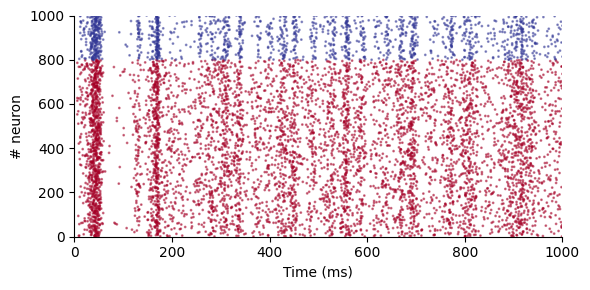

In [14]:
figure(figsize=(6, 3))
scatter(firings[:,1], firings[:,2], c=firings[:,2].<Ne, s=1, alpha=0.5, cmap="RdYlBu_r")
xlabel("Time (ms)"); ylabel("# neuron"); xlim(0, 1000); ylim(0, 1000)
tight_layout()

初めの400msぐらいまでは100msごとに約10Hzの$\alpha$波が見られ，800ms付近には約40Hzの$\gamma$波が見られる．